# 🎨 Probabilistic Models: VAE & Normalizing Flows Study
### *Variational Inference and Normalizing Flows with TensorFlow Probability*


**Project Overview:** This study investigates the synergy between **Explicit Generative Models** (Normalizing Flows) and **Implicit Latent Variable Models** (VAEs). We demonstrate the capacity of a Variational Autoencoder to learn a low-dimensional manifold from a high-complexity synthetic dataset generated via a chain of trainable Bijectors.

**Key Technical Pillars:**
* **Data Synthesis:** Mapping Multivariate Normal noise to a structured image manifold using a sequence of invertible transformations (`TransformedDistribution`).
* **Inference Network:** A Probabilistic Encoder outputting `MultivariateNormalTriL` parameters, utilizing **BatchNormalization** and **LeakyReLU** for robust training.
* **Objective Function:** Optimization of the **Evidence Lower Bound (ELBO)** to balance reconstruction fidelity and latent space continuity:

<div style="margin-left: 80px;">

$\mathcal{L} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) || p(z))$

</div>


* **Manifold Analysis:** Semantic latent space traversal and interpolation between generated samples.

In [ ]:
# Set up a quiet environment for TensorFlow and Keras operations
import os, warnings, logging

# --- 1. System & Library Silence ---
# '3' filters out all logs except FATAL errors.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
os.environ['TF_CPP_MAX_VLOG_LEVEL'] = '0' 
# Disabling oneDNN avoids long messages about floating-point precision optimizations
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 

# --- 2. Python Warning Suppression ---
# Ignore standard warnings (e.g., deprecated functions in TFP or Matplotlib)
warnings.filterwarnings('ignore')

# --- 3. TensorFlow Keras Configuration ---
# Set keras 2.x as default for tensorflow probability compatibility
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras as keras

In [2]:
# Verify keras version
print(keras.__version__)

2.19.0


In [3]:
# Import libraries
import random, requests, gc

# --- TensorFlow Logger Setup ---
# This ensures that only critical TensorFlow errors are shown in the notebook output
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors 
tfpl = tfp.layers

import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from sklearn.model_selection import train_test_split
from tf_keras.models import Sequential, Model
from tf_keras.layers import Flatten, BatchNormalization, UpSampling2D,\
  Reshape, Conv2D, Dense, InputLayer,Lambda,\
    Activation, Conv2DTranspose, LeakyReLU
from tf_keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.animation as anim
from IPython.display import HTML

In [4]:
# GPU Detection and Specification
# 1. Check if TensorFlow detects the GPU
device_name = tf.test.gpu_device_name()

if not device_name:
    print('❌ GPU device not found.')
    print('💡 Recommendation: If in Colab, to to Runtime > Change runtime type and select "T4 GPU" for significantly faster training.')
else:
    print(f'✅ Found GPU at: {device_name}')

    # 2. Identify the specific GPU model ONLY if detected
    print('\nHardware Specifications:')
    !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

I0000 00:00:1770064738.208737  143800 gpu_device.cc:2019] Created device /device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


✅ Found GPU at: /device:GPU:0

Hardware Specifications:
name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 3070 Laptop GPU, 591.44, 8192 MiB


In [5]:
# Define a function to set seeds for reproducibility
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    
    Args:
        seed (int): The seed value to use for all random number generators.

    Returns:
        None
    """
    # 1. Set Python core random seed
    random.seed(seed)

    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)

    # 4. Set TensorFlow seed (used for weight initialization)
    tf.random.set_seed(seed)

    # 5. Force TensorFlow to use deterministic algorithms (Optional)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(42)

Reproducibility set with seed: 42


In [6]:
# --- Model Initialization ---

# 1. Clear the Keras global state
tf.keras.backend.clear_session()

# 2. Force Python to find and delete orphaned objects
gc.collect()

print("🧹 GPU Memory cleared.")

🧹 GPU Memory cleared.


In [7]:
# --- 1. Universal Environment Setup ---
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    PROJECT_PATH = '/content/gdrive/MyDrive/Colab Notebooks/VAE/'
    if not os.path.exists(PROJECT_PATH):
        os.makedirs(PROJECT_PATH)
    os.chdir(PROJECT_PATH)
    BASE_DIR = './'
    print(f"✅ Environment: Google Colab. Directory: {os.getcwd()}")
except ImportError:
    BASE_DIR = '../'
    print(f"✅ Environment: Local System. Directory: {os.getcwd()}")

✅ Environment: Local System. Directory: /home/ml/projects/probabilistic-models-vae-flow/notebooks


In [8]:
# --- 2. Infrastructure & Paths ---
DATA_DIR = os.path.join(BASE_DIR, 'data/')
IMG_DIR = os.path.join(BASE_DIR, 'images/')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)

FILE_NAME = 'example_images.png'
EXAMPLE_PATH = os.path.join(IMG_DIR, FILE_NAME)
image_url = "https://github.com/fvalerii/probabilistic-models-vae-flow/blob/main/images/example_images.png?raw=true"

# --- 3. Automated Acquisition of Dataset ---
if not os.path.exists(EXAMPLE_PATH):
    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            with open(EXAMPLE_PATH, 'wb') as f:
                f.write(response.content)
            print(f"✅ Downloaded example images to {EXAMPLE_PATH}")
        else:
            print("⚠️ Could not fetch image. Check if the URL/branch name is correct.")
    except Exception as e:
        print(f"❌ Error fetching asset: {e}")

![Flags overview image](../images/example_images.png)


## 1. Normalising flow implementation
### **Synthetic Manifold Generation via Normalizing Flows**
The data generation process utilizes **Normalizing Flows** to transform a simple base distribution $p(z)$ into a complex, structured data distribution $p(x)$ through a series of invertible, differentiable mappings (Bijectors). This framework allows for exact density estimation via the Change of Variables formula.

**Key Components:**
- **Base Distribution:** A 2D isotropic Gaussian $z \sim N(\mathbf{0}, 0.3^2\mathbf{I}_2)$.
- **Stochastic Bijector Chain:** A sequence of five transformations $f_1 \dots f_5$ with randomized parameters ($\theta \sim U[0, 2\pi)$ and $a \sim N(3, 1)$), introducing non-linear structural variance.
- **Transformed Distribution:** The final variable $x = f_5 \circ f_4 \circ f_3 \circ f_2 \circ f_1(z)$ defines a complex density manifold.

**Mathematical Mapping:** The complete normalizing flow is defined by the following chain of transformations:

* **Translation:** $f_1(z) = (z_1, z_2 - 2)$
* **Scaling:**$f_2(z) = (z_1, \frac{z_2}{2})$
* **Polynomial Shear:** $f_3(z) = (z_1, z_2 + az_1^2)$
* **Rotation:** $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$.
* **Non-linearity:** $f_5(z) = \tanh(z)$, applied elementwise to constrain the output space.

The resulting densities are rendered as contour plots to generate a high-complexity synthetic image dataset (36x36x3 RGB).

In [9]:
# Define base isotropic 2D Gaussia1n distribution for normalizing flow
z = tfd.MultivariateNormalDiag(loc=tf.zeros(2), scale_diag=tf.ones(2)*0.3)

# Define uniform and normal distributions for VAE
uniform = tfd.Uniform(low=0, high=2*np.pi)
normal = tfd.Normal(loc=3, scale=1)

I0000 00:00:1770064738.951965  143800 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
# Define f3(z) bijector (shear transformation)
# it is invertible and has unit Jacobian dterminant

class F3(tfb.Bijector):
  def __init__(self, a, validate_args=False, **kwargs):
    self.a = tf.cast(a, tf.float32)
    super(F3, self).__init__(validate_args=validate_args,
                             forward_min_event_ndims=1)

  def _forward(self, x):
    x = tf.cast(x, tf.float32)
    # Define forward transformation through a quadratic transformation of second component
    return tf.stack([x[..., 0], x[..., 1] + self.a * x[..., 0]**2], axis=-1)

  def _inverse(self, y):
    y = tf.cast(y, tf.float32)
    #Define inverse transformation
    return tf.stack([y[..., 0], y[..., 1]- self.a * y[..., 0]**2], axis=-1)
  
  # Define log determinant of Jacobian as zero
  def _inverse_log_det_jacobian(self, y):
    return tf.constant(0, dtype=tf.float32)

  def _forward_log_det_jacobian(self, x):
    return tf.constant(0, dtype=tf.float32)

In [11]:
# Define f4(z) bijector (rotation transformation)
class F4(tfb.Bijector):
  def __init__(self, theta, validate_args=False, **kwargs):
    theta = tf.cast(theta, tf.float32)
    # Define rotation matrix
    self.r_matrix = tf.convert_to_tensor([[tf.cos(theta), -tf.sin(theta)],
                                 [tf.sin(theta), tf.cos(theta)]],
                                 dtype=tf.float32)
    super(F4, self).__init__(
        validate_args=validate_args,
        forward_min_event_ndims=1,)

  def _forward(self, x):
      x = tf.cast(x, tf.float32)
      return tf.linalg.matvec(self.r_matrix, x)

  def _inverse(self, y):
      y = tf.cast(y, tf.float32)
      return tf.linalg.matvec(tf.transpose(self.r_matrix), y)

  def _inverse_log_det_jacobian(self,y):
      return tf.constant(0, dtype=tf.float32)

  def _forward_log_det_jacobian(self, x):
      return tf.constant(0, dtype=tf.float32)

In [12]:
# Define function to create the normalizing thorugh bijector chain
def get_bijector(a, theta):
  f1 = tfb.Shift([0, -2])
  f2 = tfb.Scale([1, 0.5])
  f3 = F3(a)
  f4 = F4(theta)
  f5 = tfb.Tanh()
  # Chain the bijectors: Translation -> Scaling -> Shear -> Rotation -> Tanh
  bijector = tfb.Chain([f5, f4, f3, f2, f1])
  return bijector

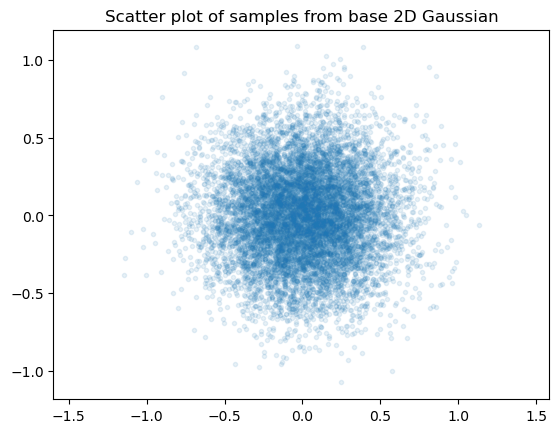

In [13]:
# Define number of samples and plot ascatter plot from base 2D Gaussian
n_samples = 10000

z_sample = z.sample(n_samples).numpy()

plt.scatter(z_sample[:, 0], z_sample[:, 1], marker='.', alpha=0.1)
plt.title('Scatter plot of samples from base 2D Gaussian')
plt.axis('equal')
plt.show()

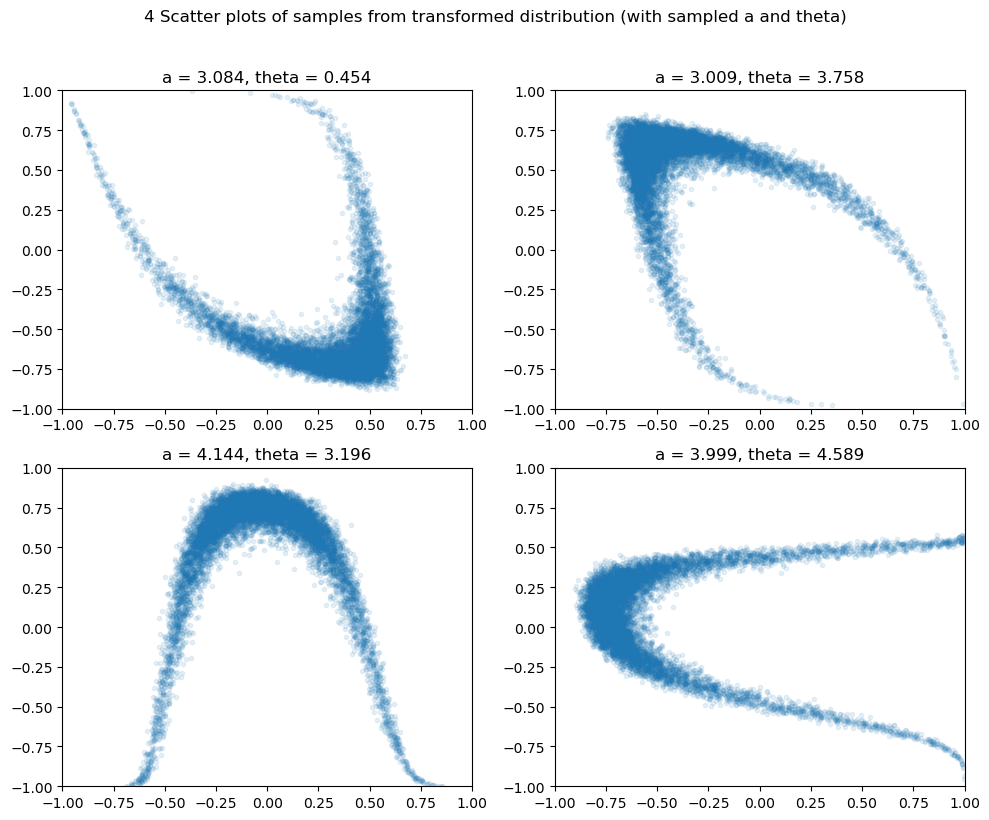

In [14]:
# Plot scatter plots of samples from transformed distribution
# 4 sets of 10,000 samples resampling a and theta for each set
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i in range(4):
    a = normal.sample()
    theta = uniform.sample()
    f_bijector = get_bijector(a, theta)
    dist = tfd.TransformedDistribution(distribution=z, bijector=f_bijector)
    dist_sample = dist.sample(n_samples).numpy()
    axs[i//2, i%2].scatter(
        dist_sample[:,0], dist_sample[:,1], marker='.', alpha=0.1)
    axs[i//2, i%2].set_xlim([-1, 1])
    axs[i//2, i%2].set_ylim([-1, 1])
    axs[i//2, i%2].set_title('a = {:.3f}, theta = {:.3f}'.format(a, theta))
fig.suptitle(
    '4 Scatter plots of samples from transformed distribution (with sampled a and theta)', y=1.02)
plt.tight_layout()
plt.show()

## 2. Image Dataset Generation
To create our training data, we used the Normalizing Flow to generate a dataset of contour plots. These plots represent the complex shapes created by the bijectors we defined. This dataset serves as the "ground-truth" that our VAE will eventually try to learn.

**Dataset Specifications:**
- **Total Samples:** 20,000 images.

- **Format:** A NumPy array with the shape `(N, 36, 36, 3)`, representing RGB image data.

- **Diversity:** Each image is unique because it uses a different set of randomly sampled parameters ($a$ and $\theta$). This creates a wide variety of shapes and rotations in the data.

**Visual Verification:**
- We first displayed **4 sample images** to see how individual parameter changes affect the shapes.

- Finally, we visualized a **grid of 20 images** from the full dataset to ensure the distribution was diverse and correctly formatted for training.


In [15]:
# Define helper function to compute transformed distribution densities
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) distribution object as an argument, and returns a numpy
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.

    Args:
        transformed_distribution: A (possibly batched) distribution object
        
    Returns:
        Z: A numpy array of shape (batch_shape, 100, 100) of density valeus
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])

    return Z

In [16]:
# Define helper function to convert contour plots to numpy arrays

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    
    Args:
        Z: A numpy array of shape (100, 100) of density values
    
    Returns:
        image_from_plot_rgb: A numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.36, 0.36))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (4,))

    #addded line to make it work with new version of matplotlib
    image_from_plot_rgb = image_from_plot[..., [1, 2, 3, 0]][..., :3]

    return image_from_plot_rgb

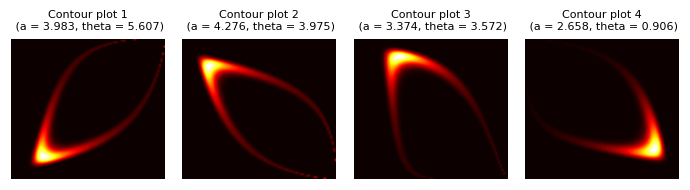

In [17]:
# Plot contour plots images of 4 samples from normalizaing flow
# with independent sample sets of parameters
fig, axs = plt.subplots(1, 4, figsize=(7, 2))

for i in range(4):
  a = normal.sample()
  theta = uniform.sample()
  f_bijector = get_bijector(a, theta)
  dist = tfd.TransformedDistribution(distribution=z, bijector=f_bijector)
  batch_dist = tfd.BatchReshape(dist, [1])
  Z = get_densities(batch_dist)
  axs[i%4].contourf(X, Y, Z[0,...], cmap='hot', levels=100)
  axs[i%4].set_title(
      'Contour plot {:d}\n (a = {:.3f}, theta = {:.3f})'.format(i+1,
          a, theta), fontsize=8)
  axs[i%4].axis('off')
fig.tight_layout()
plt.show()


In [18]:
# Generate 20000 synthetic samples to ensure the VAE has enough variety to learn the manifold
number_images = 20000
image_shape = (36, 36, 3)
images = np.empty((number_images, *image_shape), dtype=np.uint8)

for i in range(number_images):
    a = normal.sample()
    theta = uniform.sample()
    f_bijector = get_bijector(a, theta)
    dist = tfd.TransformedDistribution(distribution=z, bijector=f_bijector)
    batch_dist = tfd.BatchReshape(dist, [1])
    Z = get_densities(batch_dist).squeeze()
    images[i, ...] = get_image_array_from_density_values(Z)

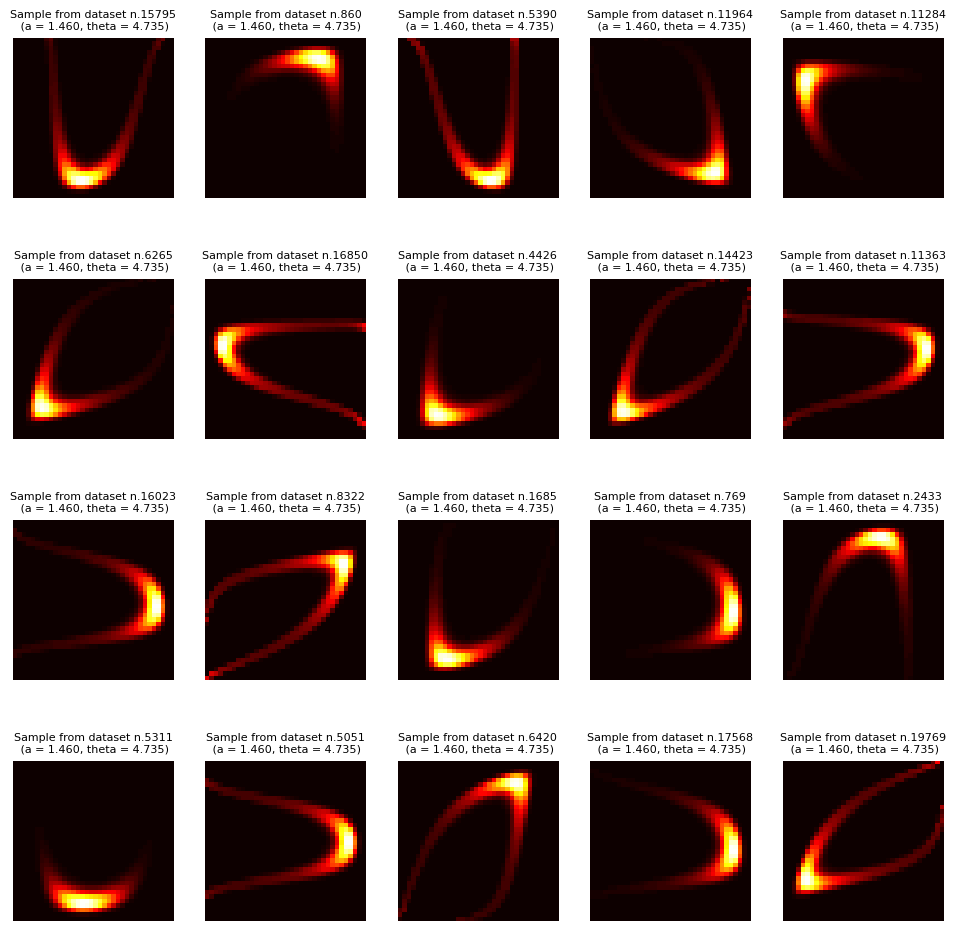

In [19]:
# Display 20 random samples from images dataset
indx = np.random.choice(number_images, 20)
fig, axs = plt.subplots(4, 5, figsize=(12,12))
for i in range(20):
    axs[i//5, i%5].imshow(images[indx[i]])
    axs[i//5, i%5].axis('off')
    axs[i//5, i%5].set_title(
      'Sample from dataset n.{:d}\n (a = {:.3f}, theta = {:.3f})'.format(indx[i],
            a, theta), fontsize = 8)
plt.show()

## 3. Data Pipeline Preparation
To train our model efficiently, we converted our raw images into a high-performance TensorFlow Data Pipeline. This ensures the model receives data in clean, organized batches.

**Key Processing Steps:**

- **Normalization:** We scaled all pixel values to be between **0 and 1**. This helps the neural network learn faster and more reliably.

- **Autoencoder Formatting:** Since a VAE learns to reconstruct its own input, we formatted the data so that each "sample" is a pair of identical images—one for the input and one for the target.

- **Splitting & Batching:**

    - The data was split into **Training** and **Validation** sets to monitor for overfitting.

    - We used a batch size of 32, meaning the model looks at 32 images at a time before updating its weights.

- **Shuffling:** The training data is shuffled in every epoch to ensure the model doesn't learn the order of the images, only the features within them.

**Validation:**

- We verified the setup by checking the `element_spec`, confirming that each batch consists of two sets of (32, 36, 36, 3) image tensors.


In [20]:
# Split the images dataset into training and validation sets
train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
val_dataset = tf.data.Dataset.from_tensor_slices(val_images)

In [21]:
# Normalize pixels to [0, 1] for better convergence
def rescale(image):
  return tf.cast(image, tf.float32)/255.

train_dataset = train_dataset.map(rescale)
val_dataset = val_dataset.map(rescale)

In [22]:
# Duplicate each image to be also output in the datasets
train_dataset = train_dataset.map(lambda x: (x,x))
val_dataset = val_dataset.map(lambda x: (x,x))

In [23]:
# Shuffle and batch datasets
train_dataset = train_dataset.shuffle(buffer_size=100)
# Batch size 32 with drop_remainder=True ensures consistent tensor shapes during training
train_dataset_batched = train_dataset.batch(32, drop_remainder=True)
val_dataset_batched = val_dataset.batch(32, drop_remainder=True)

In [24]:
# ptint element.spec for training dataset and validation dataset
train_dataset_batched.element_spec
val_dataset_batched.element_spec

(TensorSpec(shape=(32, 36, 36, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 36, 36, 3), dtype=tf.float32, name=None))

## 4. Model Architecture: The Encoder & Decoder
In this section, we build the two halves of the Variational Autoencoder (VAE). Instead of simple flat layers, we use Convolutional Neural Networks (CNNs) to help the model understand the shapes and patterns in our contour plots.

### **The Encoder: Learning the Latent Distribution**

The Encoder is designed to translate visual patterns into a mathematical distribution. Instead of just "guessing" a coordinate, it learns the **mean** and **uncertainty** of where an image belongs in the latent space.

**Key Technical Features:**

- **Feature Extraction:** Four `Conv2D` layers progressively scan the 36x36 images. By using BatchNormalization after every convolution, we ensure the model stays stable and trains faster.

- **Gradient Flow:** The **LeakyReLU** activations (with an alpha of 0.1) allow the model to learn even from negative values, preventing "dead neurons" in the deep network.

- **Probabilistic Mapping:** The `MultivariateNormalTriL` layer transforms the flattened features into a 2D Gaussian distribution. This allows for the **Reparameterization Trick**, which is essential for training generative models.

- **Automatic Regularization:** The `KLDivergenceAddLoss` layer automatically calculates how much the latent space deviates from our "perfect" Prior distribution and adds it to the total training loss.


### **The Decoder: Reconstructing the Image**

The Decoder’s job is to take a 2D coordinate from the latent space and turn it back into a full 36x36x3 image.

- **Upsampling:** We use **Conv2DTranspose** layers. Think of this as "un-scanning" or stretching the 2D coordinate back into the original image shape.

- **Fidelity:** By using the same stable layers (BatchNormalization/LeakyReLU) as the encoder, the decoder learns to produce sharp, accurate reconstructions of the original synthetic manifold.

**The Prior: The Target Space**

We define a Prior Distribution as a simple 2D Gaussian with a mean of 0. This is the "perfectly organized" shape we want our latent space to follow.

In [25]:
# Define the latent space dimensionality the event shape, and the prior.
latent_size = 2
event_shape = (36, 36, 3)
alpha = 0.1
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

In [ ]:
# Define Encoder through the Sequential API
# Architecture: Deep CNN -> Flattening -> Latent Distribution
encoder = Sequential([
    # --- Feature Extraction Blocks ---
    # We use 4 Conv2D layers with BatchNormalization to stabilize internal activations
    Conv2D(32, 3, padding='same', input_shape=event_shape),
    BatchNormalization(),
    LeakyReLU(alpha),

    Conv2D(64, 3, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha),

    Conv2D(128, 3, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha),

    Conv2D(256, 3, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha),
    # --- Bottleneck & Distribution Mapping ---
    Flatten(),
    Dense(128),
    LeakyReLU(alpha),

    Dense(64,),
    LeakyReLU(alpha),

    Dense(32),
    LeakyReLU(alpha),

    # Dynamically determine the required parameters for the Multivariate Normal output
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),

    # Parameterize the Latent Space as a Probability Distribution
    tfpl.MultivariateNormalTriL(event_size=latent_size), 

    # Apply KL-Divergence Loss to regularize the manifold toward N(0, I) with weight (Beta) =  2.0
    tfpl.KLDivergenceAddLoss(prior, weight=2.0) 
])

# Print encoder summary
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 36, 36, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 36, 36, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 36, 36, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 36, 36, 64)        0

In [27]:
# Test and verify shape of encoder output
input_batch = next(iter(train_dataset_batched))
encoder_output = encoder(input_batch[0])
encoder_output

I0000 00:00:1770066284.848144  143800 cuda_dnn.cc:529] Loaded cuDNN version 90600


<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[32] event_shape=[2] dtype=float32>

In [28]:
# Verify KL Divergence is being calculated
encoder.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.47888508439064026>]

In [29]:
# Define Decoder through the Sequential API
# DECODER: Latent Vector -> Learned Upsampling -> Reconstructed Image
decoder = Sequential([
    Dense(4 * 4 * 1024, activation='relu', input_shape=(latent_size,)),
    Reshape((4, 4, 1024)),

    # Conv2DTranspose used for learnable upsampling from latent vector to image
    # First upsampling: (4, 4) -> (8, 8)
    Conv2DTranspose(512, 4, strides=(2, 2), padding='same'),
    # Mirroring the encoder's normalization and activation strategy
    BatchNormalization(),
    LeakyReLU(alpha),

    # Second upsampling: (8, 8) -> (16, 16)
    Conv2DTranspose(256, 4, strides=(2, 2), output_padding=1, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha),

    # Third upsampling: (16, 16) -> (32, 32)
    Conv2DTranspose(128, 4, strides=(2, 2), output_padding=1, padding='valid'),
    BatchNormalization(),
    LeakyReLU(alpha),

    # Fine-tuning step: (32, 32) -> (35, 35)
    Conv2DTranspose(64, 4, strides=(1, 1), padding='valid'),
    BatchNormalization(),
    LeakyReLU(alpha),

    # Final adjustment: (35, 35) -> (36, 36)
    Conv2D(3, 3, strides=(1, 1), padding='same'),  # Adjust padding to match target shape
    Flatten(),

    tfpl.IndependentBernoulli(event_shape=event_shape) # Output distribution through Independent Bernoulli
])
# Print decoder summary
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16384)             49152     
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         8389120   
 anspose)                                                        
                                                                 
 batch_normalization_4 (Bat  (None, 8, 8, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 15, 15, 256)      

In [30]:
# Test decoder for correct output shape
decoder(tf.random.uniform([1, latent_size]))

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[36, 36, 3] dtype=float32>

## 5. Model Training & The ELBO Objective
In this stage, we combine the Encoder and Decoder into a single **Variational Autoencoder (VAE)** and train it to master the patterns in our synthetic dataset.

**Model Assembly**

- **The Unified Model:** We used the Keras `Model` class to "glue" the Encoder and Decoder together. This creates a complete pipeline: Image $\rightarrow$ Latent Space $\rightarrow$ Reconstructed Image.

- **Summary Check:** The model summary provides a final check of the layers, ensuring the spatial dimensions are correctly reduced by the Encoder and expanded back by the Decoder.

**The Training Objective**

- **Optimizing the ELBO:** We train the model to minimize the **Negative Log-Likelihood.** This effectively optimizes the **Evidence Lower Bound (ELBO)**, which is a balance between:

    1. **Reconstruction Quality:** Making the output image look exactly like the input.

    2. **Latent Regularization:** Ensuring the latent space stays organized and follows our standard Gaussian prior (via the KL Divergence).

- **Data Flow:** Training is performed using the `fit` method on our high-performance data pipelines, using the validation set to monitor performance in real-time.

**Performance Analysis**

- **Convergence:** The training results show **rapid convergence within the first 5 epochs**. This indicates that the combination of CNNs, BatchNormalization, and LeakyReLU is highly efficient at learning the structure of the Normalizing Flow manifold.

- **Generalization:** The training and validation curves track each other closely, proving that the model generalizes well and hasn't just "memorized" the training images.

In [31]:
# Assemble the VAE by linking the inference (encoder) and generative (decoder) networks
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 36, 36, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 36, 36, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 36, 36, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 36, 36, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 36, 36, 64)        256       
 chNormalization)                                            

In [32]:
# Define function that calculates reconstruction loss
def reconstruction_loss(batch_of_images, decod_dist):
  '''
Computes the reconstruction component of the ELBO objective.
    
This function calculates the expected log-likelihood of the input data 
under the decoder's output distribution. A lower negative log-likelihood 
indicates higher reconstruction fidelity.

Args:
    batch_of_images: Ground truth image tensors from the Normalizing Flow.
    decod_dist: The probability distribution output by the Decoder.
    
Returns:
    Scalar tensor representing the average Negative Log-Likelihood (NLL).
  '''
  return -tf.reduce_mean(decod_dist.log_prob(batch_of_images))

In [33]:
# Stop if validation loss doesn't improve for 3 consecutive epochs
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

In [34]:
# Compile model
optimizer = Adam(learning_rate=0.0001)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [ ]:
# Fit the model
history = vae.fit(
    train_dataset_batched, 
    validation_data=val_dataset_batched, 
    epochs=20, 
    callbacks=[early_stop],
    verbose=1)

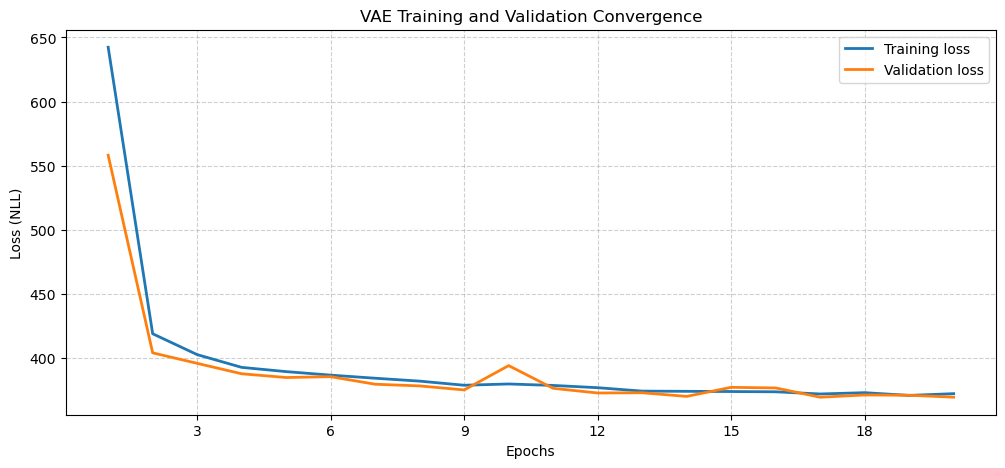

In [36]:
# Plot training and validation loss curves
# Define the epoch range starting from 1
epochs = range(1, len(history.history['loss']) + 1)

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the training and validation loss
ax.plot(epochs, history.history['loss'], label='Training loss', linewidth=2)
ax.plot(epochs, history.history['val_loss'], label='Validation loss', linewidth=2)

# Force the x-axis to use only integer ticks
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Customize the plot
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (NLL)')
ax.set_title('VAE Training and Validation Convergence')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Save the figure to images folder
IMAGE_PATH = os.path.join(IMG_DIR, 'loss_curves.png')
plt.savefig(IMAGE_PATH, dpi=300, bbox_inches='tight')
plt.show()

## 6. Manifold Evaluation & Reconstruction Fidelity

### Quantitative Evaluation: Fréchet Inception Distance (FID)

To quantitatively evaluate the quality and diversity of our generated Normalizing Flow contours, we use the **Fréchet Inception Distance (FID)**.

**The Concept**

FID measures the "distance" between two distributions: the **Real** images from our dataset and the **Fake** images generated by the Decoder.

- A **lower score** (closer to 0) indicates that the generated images are statistically indistinguishable from the real ones.

- A **higher score** suggests the model is failing to capture the full variety of the manifold or is producing artifacts.

**Our Implementation**

Unlike standard FID which uses an InceptionV3 model trained on natural photos (cats/dogs), we use our **trained Encoder** as a domain-specific feature extractor. This is more accurate for synthetic data because:

**1. Domain Alignment:** Our Encoder already understands the specific "language" of $a$ and $\theta$ parameters.

**2. Feature Relevance:** It focuses on the topological structure of the contours rather than irrelevant textures.

**The Math**

We calculate the distance between the mean ($\mu$) and covariance ($\Sigma$) of the latent features:

$$d^2 = \|\mu_{real} - \mu_{fake}\|^2 + Tr(\Sigma_{real} + \Sigma_{fake} - 2\sqrt{\Sigma_{real}\Sigma_{fake}})$$

**Interpreting the Results**
| Metric Range | Latent Topology | Model Quality | Significance |
| :--- | :---: | :---: | :--- |
| **0.0 - 1.0** | Perfect Circle/Butterfly | **Excellent** | Distribution is indistinguishable from Real Data. |
| **1.0 - 10.0** | Defined Clusters | **Good** | Major modes captured; minor loss in contour variance. |
| **10.0 - 50.0** | Fractured/Sparse | **Fair** | Visible artifacts; "Void" zones in latent space. |
| **> 50.0** | Collapsed/Noisy | **Poor** | Mode collapse; Decoder failing to recover geometry. |

In [37]:
# FID Evaluation Procedure
print("\n" + "="*10 + " FID EVALUATION PROCEDURE " +"="*10 + "\n")
# --- Configuration ---
N_SAMPLES = 1000  # Safe sample size for T4 GPU
BATCH_SIZE = 32   # Prevents ResourceExhaustedError (OOM)

def calculate_fid(real_features, fake_features):
    """Computes the Fréchet Distance between two multivariate Gaussians."""
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    
    # Squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # Product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Correct numerical noise (imaginary numbers)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    return ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

def get_latent_features(images, model):
    """Passes images through encoder in small batches to avoid OOM."""
    all_mu = []
    for i in range(0, len(images), BATCH_SIZE):
        batch = images[i:i+BATCH_SIZE]
        batch_tensor = tf.convert_to_tensor(batch, dtype=tf.float32)
        dist = model(batch_tensor)
        # Use mean of the latent distribution as the representative feature
        mu = dist.mean().numpy() if hasattr(dist, 'mean') else dist.numpy()
        all_mu.append(mu)
    return np.concatenate(all_mu, axis=0)

# 1. Grab Real Images Safely
# val_dataset_batched (images, images)
print("📦 Extracting real images from dataset...")
raw_batch = next(iter(val_dataset_batched.unbatch().batch(N_SAMPLES)))
real_images_subset = raw_batch[0].numpy()

# 2. Generate Fake Images in Batches
print("🎨 Generating synthetic images via Decoder batches...")
z_samples = prior.sample(N_SAMPLES)
gen_images_list = []

for i in range(0, N_SAMPLES, BATCH_SIZE):
    z_batch = z_samples[i : i + BATCH_SIZE]
    gen_dist_batch = decoder(z_batch)
    
    # Extract mean pixels and move to System RAM (numpy) immediately
    img_batch = gen_dist_batch.mean().numpy()
    gen_images_list.append(img_batch)

gen_images = np.concatenate(gen_images_list, axis=0)

# 3. Extract Latent Features (The FID Comparison Space)
print("🔍 Extracting features for Real images...")
real_f = get_latent_features(real_images_subset, encoder)

print("🔍 Extracting features for Fake images...")
fake_f = get_latent_features(gen_images, encoder)

# 4. Final FID Calculation
fid_score = calculate_fid(real_f, fake_f)

print("\n" + "="*40)
print(f"✅ FID EVALUATION COMPLETE")
print(f"📊 Samples used: {N_SAMPLES}")
print(f"🏆 FID Score: {fid_score:.4f}")
print("="*40)


========== FID EVALUATION PROCEDURE ==========

📦 Extracting real images from dataset...
🎨 Generating synthetic images via Decoder batches...
🔍 Extracting features for Real images...
🔍 Extracting features for Fake images...

✅ FID EVALUATION COMPLETE
📊 Samples used: 1000
🏆 FID Score: 0.4473


- The achieved FID of 0.4473 places this model firmly in the 'Excellent' category, confirming that the latent manifold is statistically consistent with the ground-truth Normalizing Flow distribution.

### Qualitative Inference and Evaluation

In this final stage, we conduct "inference" to test how well our model has understood the synthetic data. We evaluate three specific areas: the organization of the latent space, the accuracy of reconstructions, and the quality of new image generation.

**1. Latent Space Visualization**

We passed 1,000 images through the encoder and plotted their 2-dimensional "embeddings" on a scatter plot.

- **What this shows:** If the points are well-distributed and not clumped into a single messy pile, it proves that the KL Divergence regularizer worked. It shows the model has created a continuous, organized "map" of the data.

**2. Image Reconstruction (Original vs. VAE)**

We randomly selected 4 images from the dataset to see how well the VAE could "copy" them.

- **The Method:** We used the **mean** of the decoder's output distribution. This gives us the "cleanest" and most likely version of the image without the random noise of a single sample.

- **The Goal:** To verify that the **Convolutional layers** (CNN) are capturing the sharp edges and specific shapes of the original contour plots.

**3. Generating New Samples from the Prior**

To test the "Generative" part of the VAE, we sampled 6 random coordinates directly from our 2D Gaussian Prior ($N(0, I)$).

- **Synthesis:** Since these points didn't come from any existing image, the results are entirely new synthetic images.

- **Quality Check:** This confirms that the model hasn't just memorized the training set, but has learned the "rules" of how to draw a contour plot from any coordinate in the latent space.

In [38]:
# Define function to sample images from dataset

def get_sample_images(sample_size):
    '''
    This function returns a sample of images from the dataset.
    Args:
        sample_size: Number of images to sample from the dataset.
    Returns: 
        sample_images: A numpy array of shape (sample_size, 36, 36, 3) of sampled images normalized to [0., 1.]
    '''
    indx = np.random.choice(
        number_images, sample_size, replace = False)
    sample_images = images[indx]/255.
    return sample_images

In [39]:
# Sample images to pass through encoder
n_images_scatter = 1000

sample_images_scatter = np.array(get_sample_images(n_images_scatter))
sample_images_scatter.shape

(1000, 36, 36, 3)

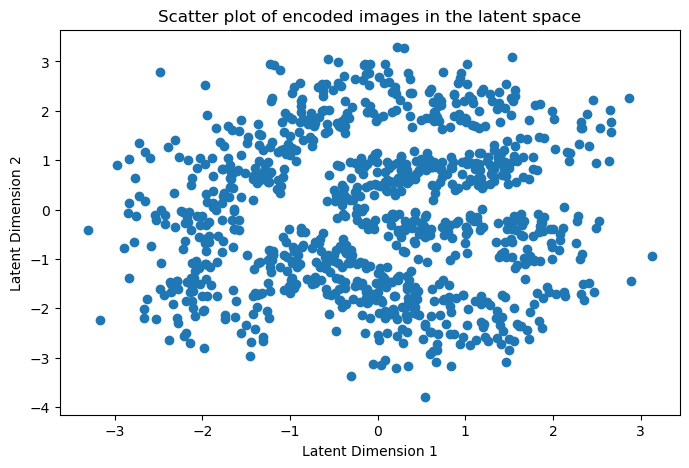

In [40]:
# --- Latent Scatter Plot ---
# Visualize 1000 samples to verify that the latent space is continuous and well-organized
encoded_images = encoder(sample_images_scatter)

fig ,axs = plt.subplots(figsize=(8,5))
axs.scatter(encoded_images[:,0], encoded_images[:,1])
plt.title('Scatter plot of encoded images in the latent space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

# Save and show the plots
IMAGE_PATH = os.path.join(IMG_DIR, 'latent_space_scatter.png')
plt.savefig(IMAGE_PATH, dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# --- Reconstruction Test ---
# Use the mean of the output distribution for the most stable, noise-free reconstruction
n_images_reconstruct = 4

sample_images = np.array(get_sample_images(n_images_reconstruct))
sample_images.shape

sample_images_reconstr = vae(sample_images).mean()

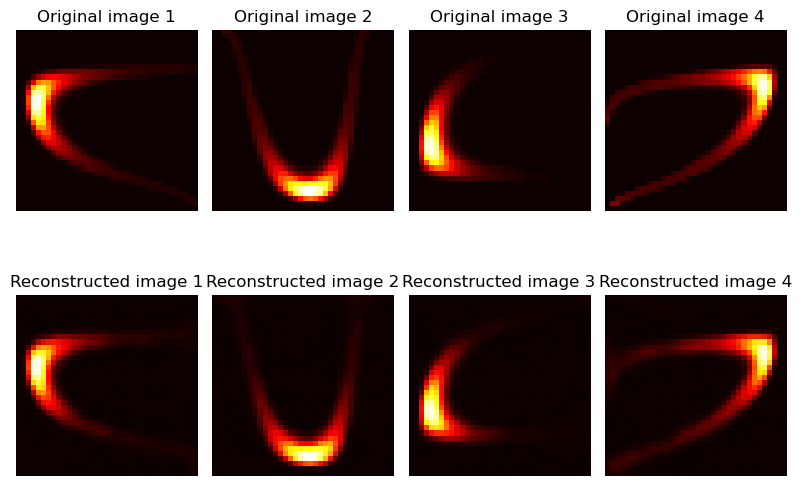

In [42]:
# Display original and reconstructed images
fig, axs = plt.subplots(2, n_images_reconstruct, figsize=(8, 6))
for t in range(n_images_reconstruct):
  axs[0, t].imshow(sample_images[t])
  axs[0, t].set_title(f'Original image {t+1}')
  axs[0, t].axis('off')
  axs[1, t].imshow(sample_images_reconstr[t])
  axs[1, t].set_title(f'Reconstructed image {t+1}')
  axs[1, t].axis('off')
plt.tight_layout()

# Save and show the plots
IMAGE_PATH = os.path.join(IMG_DIR, 'reconstruction_comparison.png')
plt.savefig(IMAGE_PATH, dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# --- Sampling from Prior ---
# Generate completely new images by sampling from the 2D Gaussian prior manifold
latent_samples = prior.sample(6)

decoded_prior_samples = decoder(latent_samples).mean()

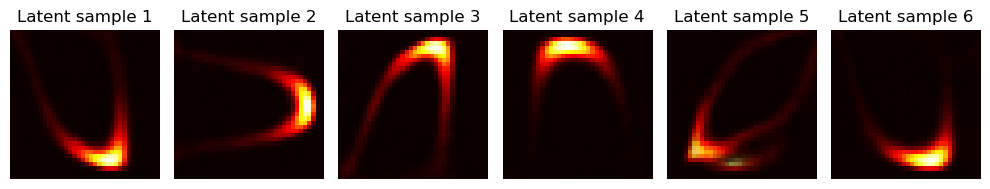

In [44]:
# Plot the reconstructions of latent samples
fig, axs = plt.subplots(1, 6, figsize=(10,6))
for t in range(6):
    axs[t].imshow(decoded_prior_samples[t])
    axs[t].set_title(f'Latent sample {t+1}')
    axs[t].axis('off')
    
plt.tight_layout()

# Save and show the plots
IMAGE_PATH = os.path.join(IMG_DIR, 'latent_samples_reconstruction.png')
plt.savefig(IMAGE_PATH, dpi=300, bbox_inches='tight')
plt.show()

### Latent Space Traversal & Video Generation
In this final stage, we test how well the model learned the underlying "logic" of the images. By moving between different points in the 2D latent space and decoding them into a video, we can visualize the manifold's continuity.

**Evaluation Criteria:**

- **Smooth Morphing:** As we move through the latent space, the images should transition naturally from one shape to another. Jumpy or flickering frames would suggest "holes" in the model's understanding.

- **Manifold Density:** Every coordinate in our path should produce a clear, recognizable contour plot. This confirms that the latent space is dense and well-regularized.

- **Evidence of Learning:** Successful synthesis proves that the VAE has not just memorized specific training images, but has truly learned the mathematical "rules" of the Normalizing Flow dataset.

In [45]:
# Define function to create animation that interpolates in latent space

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    '''
    This function creates an animation that interpolates in the latent space.
    
    Args:
        latent_size: Dimensionality of the latent space.
        decoder: The decoder model to generate images from latent variables.
        interpolation_length: Number of frames in the animation.
    
    Returns:
        anim.FuncAnimation object that can be displayed in a Jupyter notebook.
    '''
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i):
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data([z.numpy()[0]], [z.numpy()[1]])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length,
                              repeat=False, blit=True, interval=150)

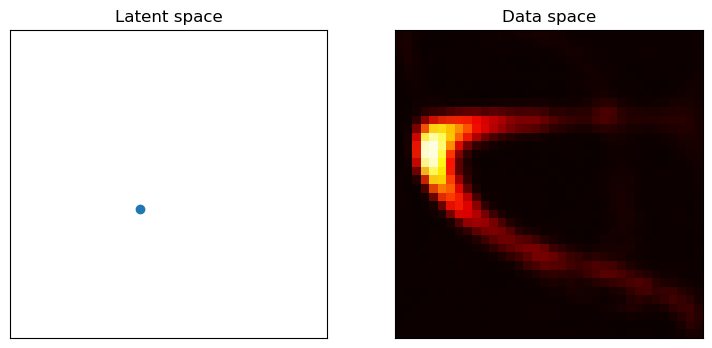

In [46]:
# Create the animation

anim = get_animation(latent_size, decoder, interpolation_length=200)
HTML(anim.to_html5_video())

## 7. Conclusion & Future Work
### **Project Summary**
This study successfully combined two different types of AI models:

**1. A Normalizing Flow** to create a complex, custom dataset of images.

**2. A Variational Autoencoder (VAE)** to analyze those images and "compress" them into a simple 2D map.

The smooth interpolation between generated samples confirms that the VAE successfully recovered the underlying latent factors of the Normalizing Flow.

**Key Observations:**

- **Model Convergence:** The stabilization of the ELBO objective indicates a successful balance between reconstruction accuracy and latent space regularization.

- **Structural Fidelity:** By using Convolutional layers and BatchNormalization, the model maintained sharp edges and consistent color mappings, even when generating entirely new samples.

- **Continuous Geometry:** Moving through the 2D latent space results in smooth transitions, proving the model has learned a continuous geometry rather than a disjointed set of samples.


### **Future Directions**
- **Higher Dimensions:** Expanding the latent space beyond 2D to capture even more complex image features.

- **Different Flows:** Experimenting with specialized bijectors (like RealNVP) to create more varied synthetic distributions.

- **Autoregressive Flows:** Experimenting with Masked Autoregressive Flows (MAF) or Inverse Autoregressive Flows (IAF) to compare density estimation performance against RealNVP.